# Python Bindings for C++ Code



## Building your code:

Recommended: With CMake!
```
find_package(pybind11 CONFIG)
...
pybind11_add_module(module_name bindings.cpp)
target_link_libraries(module_name module_libraries)
```

By hand:

In [1]:
!python -m pybind11 --include

-I/usr/include/python3.9 -I/usr/include/pybind11


Then `g++ -o module_name.so -shared -fPIC $(python -m pybind11 --include) pybindings.cpp -Wl,-rpath,shared_library_dir project_library.so`

In [2]:
import platform
print(platform.python_version())
# Set Pybind11 Python version with '-D PYBIND11_PYTHON_VERSION="3.9"'

3.9.12


## Exporting To Python

```C++
#include <pybind11/pybind11.h>

namespace py = pybind11;

PYBIND11_MODULE(module_name, module) {
  module.doc() = "My Python module";
  // Exported classes, methods, enums, etc.
}
```

* `module_name` must match the name of the shared library
* `module` is an object that represents the module as seen by Python - all exports go through it
 * `module.doc() = "..."` specifies the docstring Python uses for the module

## Exporting Functions

Exporting Functions
```C++
int cppFunction1();
int cppFunction2(int, int);
std::vector<double> cppFunction3(int, double, const std::vector<int> &);
...
module.def("PythonName1", &cppFunction1, "Function1 Docstring");
module.def("PythonName2", &cppFunction2, "Function2 Docstring");
module.def("PythonName3", &cppFunction3, "Function3 Docstring");
```

Calling them from Python
```Python
import module_name

module_name.cppFunction1()
module_name.cppFunction2(3, 6)
module_name.cppFunction3(6, 34.50, [1, 2, 3, 4])
```


## Exporting Functions

Exporting Functions
```C++
int cppFunction1();
int cppFunction2(int, int);
std::vector<double> cppFunction3(int, double, const std::vector<int> &);
...
module.def("PythonName1", &cppFunction1, "Function1 Docstring");
module.def("PythonName2", &cppFunction2, "Function2 Docstring");
module.def("PythonName3", &cppFunction3, "Function3 Docstring");
```
is magick...

* Pybind11 automatically detects the number of parameters to exported functions and sets up the export to inform Python of the number of parameters
* Pybind11 also automatically detects the types of parameters to exported functions. Pybind11 converts parameters recieved from Python to the types needed by the functions, and errors when they can't be converted.
* Pybind11 finally detects the type of parameter returned by the exported function and converts it to an equivalent Python type.

## Exporting Classes

```C++
class MyClass {
public:
    double method1();
    ...
};
...
py::class_<MyClass> myClassExport(module, "PythonClassName", "MyClass Docstring")
# Then, to export a public method
myClassExport.def("methodName1", &MyClass::method1, "MyClass method1 Docstring")
```

Again, Pybind11 automatically detects the parameters and return type

What about constructors?


## Special Class Member Methods

```C++
class MyClass {
public:
    MyClass(ConstructorParamType1, ConstructorParamType2, ConstructorParamType3);
    double operator()(ParamType1, ParamType2);
    ...
};
```

`py::init<>` specifies a constructor to be exported:
```C++
myClassExport.def(py::init<ConstructorParamType1, ConstructorParamType2, ConstructorParamType3>(),
                  "MyClass constructor Docstring");
```
Types are not automatically deduced and must be specified as template parameters to `py::init<>`

What about `operator[()+-*/]`?

Python has special member methods for these, `__call`, `__add__`, `__sub__`, `__mul__`, `__floordiv__` (or `__rtruediv__`), respectively

```C++
myClassExport.def("__call__", &MyClass::operator());
myClassExport.def("__add__", &MyClass::operator+);
myClassExport.def("__sub__", &MyClass::operator-);
myClassExport.def("__mul__", &MyClass::operator*);
myClassExport.def("__floordiv__", &MyClass::operator/);
```


## Overloaded Functions/Methods

C++ needs to be able to resolve `&FunctionName` to a specific function implementation.
```C++
RetType myFunc(int a, int b) { ... }
RetType myFunc(std::vector<int> vals) { ... }
```
Which function does `&myFunc` refer to?
...
We can force the compiler to choose a specific one with a static_cast:
```C++
module.def("myFunc", static_cast<RetType (*)(int, int)>(&myFunc));
```

For an object it's a little different:
```C++
class MyClass {
public:
    RetType myMethod(int, int);
    RetType myMethod(std::vector<int>);
};

myClassExport.def("myMethod",
                  static_cast<RetType (MyClass::*)(std::vector<int>)>(&MyClass::myMethod));
```


## Memory Ownership

Python doesn't expect developers to care about memory ownership. This can cause issues with C++ which does expect developers to care about memory ownership.

```C++
class Dependent {
    int *data;
public:
    Dependent(int *d) data(d) { ... }
    int usesData() { ... }
};
```

```Python
def buildDependent():
    d = 4
    return Dependent(d)

item = buildDependent()
item.usesData()
```
What happens here?

## Memory Ownership

We need to inform Pybind of the memory ownership issue
* Method 1:
```C++
class Dependent {
    std::shared_ptr<int> data;
public:
    Dependent(std::shared_ptr<int> d) data(d) { ... }
    int usesData() { ... }
};
```
Note that this is somewhat fragile:
```C++
class Dependent {
    std::shared_ptr<int> data;
public:
    Dependent(std::shared_ptr<int> d) data(d) { ... }
    int usesData() { ... }
    int *getData() { return data.get(); }
};
```
Calling getData in Python will likely lead to a segmentation fault

* Method 2:
```C++
class Dependent {
    std::shared_ptr<int> data;
public:
    Dependent(std::shared_ptr<int> d) data(d) { ... }
    int usesData() { ... }
};
```


In [3]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import gda_bindings

matplotlib.rcParams['figure.figsize'] = (20, 20)

def plot_2d_hist_surface(pts):
    h, xedges, yedges = np.histogram2d(pts[:, 0], pts[:, 1], bins=25)
    xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = 0
    dx = dy = 0.9 * np.ones_like(zpos)
    dz = h.ravel()
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')
    return ax


<Axes3DSubplot:>

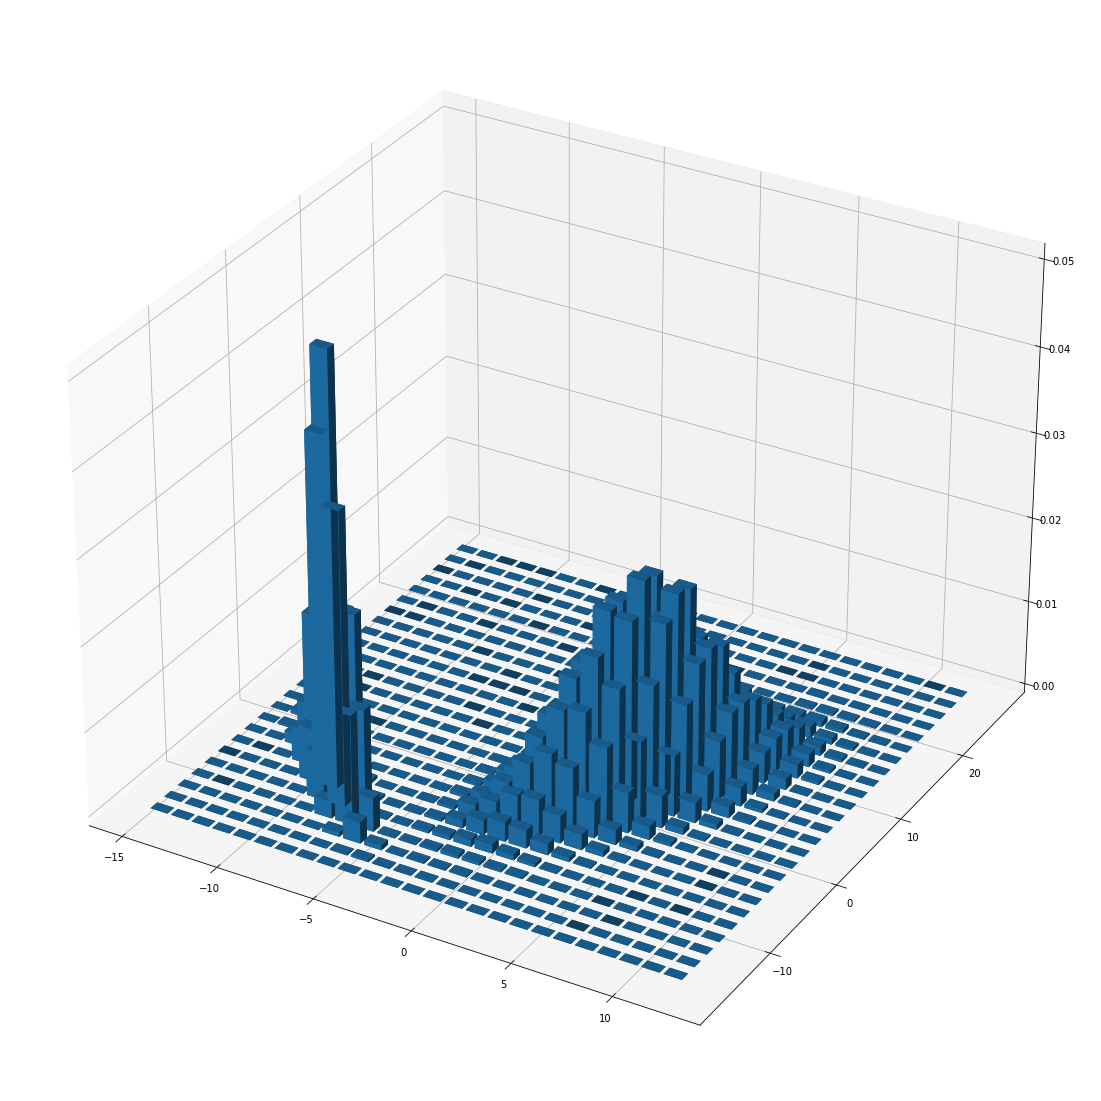

In [4]:
p1 = gda_bindings.GaussianParams([3, 4],
                                 [[2, 1],
                                  [1, 5]])
p2 = gda_bindings.GaussianParams([-9, -7],
                                 [[1, -1],
                                  [-1, 2]])
m1 = gda_bindings.GaussianMix([(0.75, p1), (0.25, p2)])
pts = np.array([m1() for i in range(100000)])
plot_2d_hist_surface(pts)